In [15]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, GRU, SimpleRNN, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('../collected_base_spk_embeddings.csv')

# Normalize data
cols = df.shape[1]
print("cols:", cols)
scaler = MinMaxScaler()
# Normalize only the columns starting from index 1 (ignoring the first column)
df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])

print("Normalized data sample:")
print(df.head())

cols: 161
Normalized data sample:
   Steps        T1        T2        T3        T4        T5        T6  \
0      0  0.573310  0.550155  0.457716  0.461512  0.460352  0.443940   
1      1  0.595997  0.554249  0.523216  0.520382  0.536814  0.547027   
2      2  0.585145  0.551853  0.505460  0.501605  0.511856  0.542829   
3      3  0.806546  0.784783  0.719851  0.735161  0.759194  0.760814   
4      4  0.904201  0.787532  0.784727  0.784202  0.790244  0.762056   

         T7        T8        T9  ...      T151      T152      T153      T154  \
0  0.379340  0.419321  0.456310  ...  0.213971  0.256358  0.255994  0.311919   
1  0.546023  0.536130  0.503208  ...  0.391715  0.445253  0.437342  0.420610   
2  0.570745  0.604794  0.609691  ...  0.530078  0.596636  0.499355  0.539187   
3  0.732930  0.705573  0.632141  ...  0.609210  0.633631  0.618911  0.689440   
4  0.705686  0.771727  0.816384  ...  0.671163  0.640372  0.673959  0.773690   

       T155      T156      T157      T158      T159 

In [19]:
# Creates sequence data for RNN
def create_sequences_data(df, cols, seq_length):
    num_cases = len(df) // seq_length   # samples
    data = df[cols].values[:num_cases*seq_length]
    X, y = [], []

    for case in range(num_cases):
        start = case * seq_length
        end = start + seq_length
        block = data[start:end]

        # Create sliding windows within this block
        # Each sequence will be seq_length-1 timesteps predicting the next timestep
        seq_x = block[:seq_length - 1]  # input: timesteps
        seq_y = block[seq_length - 1]    # target: next timestep
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)



# Hyperparameters
seq_length = 99   # how many past timesteps to use as input
input_size = cols-1  # number of features

# Create dataset
X, y = create_sequences_data(df, df.columns[1:], seq_length)
print("X shape:", X.shape)  # (num_samples, time, thick)
print("y shape:", y.shape)  # (num_samples, time, thick)

X shape: (16, 98, 160)
y shape: (16, 160)


In [20]:
# Split into training (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print("Training shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Training shape: (12, 98, 160) (12, 160)
Test shape: (4, 98, 160) (4, 160)


In [21]:
# Define all the models to test
models = {
    # 0.01132
    "GRU_128_64": Sequential([
        GRU(128, return_sequences=True, input_shape=(seq_length, input_size)),
        Dropout(0.2),
        GRU(64),
        Dense(input_size)
    ]),
}

histories = {}
evaluations = {}

for name, model in models.items():
    print(f"\nTraining model: {name}")
    print("===============================")
    model.compile(optimizer='adam', loss='mean_absolute_error')
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=32*2,
        verbose=1
    )
    
    histories[name] = history

    # Evaluate the model on the test data
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    evaluations[name] = test_loss
    print(f"Test Loss for {name}: {test_loss}")

print("\nFinal Test Evaluations:")
for name, test_loss in evaluations.items():
    print(f"{name}: Test Loss = {test_loss}")

d:\ComputerSmart\Models\index-tts\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training model: GRU_128_64
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.6743 - val_loss: 0.5202
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.5900 - val_loss: 0.4640
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.5224 - val_loss: 0.4340
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.4800 - val_loss: 0.4094
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.4492 - val_loss: 0.3849
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.4167 - val_loss: 0.3652
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.3914 - val_loss: 0.3477
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.3693 - val_loss: 0.3303
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.3466 - val_loss: 0.3099
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.3222 - val_loss: 0.2876
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.2988 - val_loss: 0.2657
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Final Losses (from last epoch):
GRU_128_64      -> Train: 0.08340, Val: 0.13210


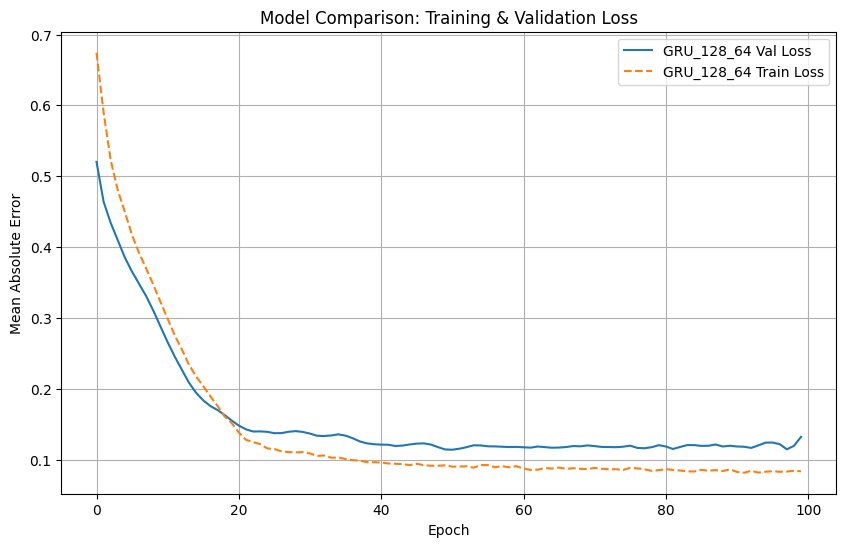

In [22]:
# Extract last training and validation losses from each history
summary = {}
for name, history in histories.items():
    last_train_loss = history.history['loss'][-1]
    last_val_loss = history.history['val_loss'][-1]
    summary[name] = {
        'train_loss': last_train_loss,
        'val_loss': last_val_loss
    }

# Print nicely
print("Final Losses (from last epoch):")
for name, losses in summary.items():
    print(f"{name:15s} -> Train: {losses['train_loss']:.5f}, Val: {losses['val_loss']:.5f}")

# Plot training & validation loss (looked this up)
plt.figure(figsize=(10,6))

for name, history in histories.items():
    plt.plot(history.history['val_loss'], label=f"{name} Val Loss")
    plt.plot(history.history['loss'], linestyle='--', label=f"{name} Train Loss")

plt.title("Model Comparison: Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Find the 61st element for all 10,000 test cases. OH NO! >:3 hehehehehe



def create_sequence_chunks(df, cols, seq_length):
    data = df[cols].values
    num_cases = len(data) // seq_length  # Number of test cases
    data = data[:num_cases * seq_length] # trim remainder if any

    # reshape into (num_cases, seq_length, num_features)
    X = data.reshape(num_cases, seq_length, len(cols))
    return X

X_test = create_sequence_chunks(df, df.columns[1:], seq_length)
print("X_test shape:", X_test.shape)    # (num_cases, seq_length, num_features)

# Predict the next (61st) timestep for each case
y_pred = models['GRU_128_64'].predict(X_test)
print("Predicted shape:", y_pred.shape)  # (num_cases, num_features)

# Invert normalization to original scale
y_pred_original = scaler.inverse_transform(y_pred)

# Convert to DataFrame for inspection or saving
pred_df = pd.DataFrame(y_pred_original, columns=df.columns[1:])
pred_df.insert(0, 'sequence_id', range(0, len(pred_df)))
pred_df.to_csv('predictions.csv', index=False)

print(pred_df.head())

X_test shape: (16, 99, 160)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted shape: (16, 160)
   sequence_id        T1        T2        T3        T4        T5        T6  \
0            0  0.145407 -0.128508 -0.122833  0.303607  0.646514  0.842945   
1            1  0.669531 -0.040866 -0.065363  0.743464  0.882250  1.258589   
2            2  0.223806 -0.231291 -0.171554  0.463403  0.714453  0.884076   
3            3  0.774770 -0.015663  0.139817  0.378772  0.731755  0.962110   
4            4  0.440659  0.224142  0.106310  0.781411  0.997128  1.131591   

         T7        T8        T9  ...      T151      T152      T153      T154  \
0  0.837238  0.959819  0.374148  ...  0.744230  0.708953  0.624727  0.571860   
1  1.440924  1.323750  0.307133  ...  1.264507  1.181781  0.829932  1.172611   
2  0.959119  0.781497  0.103707  ...  1.017200  0.617578  0.616707  0.877038   
3  1.044515  0.936693  0.390704  ...  0.848632  0.540720  0.507359  0.542832   
4  1.093108  1.003801  0.414628  ...  